In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

In [2]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [3]:
data_dir = "PetImages"

img_size = (180, 180)
batch_size = 32

In [26]:
import os
from PIL import Image

dataset_path = "PetImages"

bad_images = []

for folder in ["Cat", "Dog"]:
    folder_path = os.path.join(dataset_path, folder)

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        try:
            img = Image.open(file_path)
            mode = img.mode  # e.g. "RGB", "L", "RGBA", "LA", "P"
            if mode not in ["RGB", "L", "RGBA"]:
                print(f"Bad image with mode {mode}:", file_path)
                bad_images.append(file_path)
        except Exception as e:
            print("Unreadable:", file_path)

print("\nTotal bad images found:", len(bad_images))


Total bad images found: 0


In [20]:
from PIL import Image
import os

fixed = 0
deleted = 0

for path in bad_images:
    try:
        # Open and immediately load into memory (forces file release)
        with Image.open(path) as img:
            img.load()  # fully loads image and closes file handle

            # Convert to RGB
            rgb_img = img.convert("RGB")

        # Save AFTER image is closed
        rgb_img.save(path)
        fixed += 1

    except Exception as e:
        print("Deleting (could not convert):", path, "| Reason:", e)
        try:
            os.remove(path)
            deleted += 1
        except Exception as e2:
            print("Could not delete:", path, "| Reason:", e2)

print("\nImages fixed:", fixed)
print("Images deleted:", deleted)

Deleting (could not convert): PetImages\Cat\11095.jpg | Reason: [Errno 22] Invalid argument: 'PetImages\\Cat\\11095.jpg'
Could not delete: PetImages\Cat\11095.jpg | Reason: [WinError 32] The process cannot access the file because it is being used by another process: 'PetImages\\Cat\\11095.jpg'
Deleting (could not convert): PetImages\Cat\12080.jpg | Reason: [Errno 22] Invalid argument: 'PetImages\\Cat\\12080.jpg'
Could not delete: PetImages\Cat\12080.jpg | Reason: [WinError 32] The process cannot access the file because it is being used by another process: 'PetImages\\Cat\\12080.jpg'
Deleting (could not convert): PetImages\Cat\5370.jpg | Reason: [Errno 22] Invalid argument: 'PetImages\\Cat\\5370.jpg'
Could not delete: PetImages\Cat\5370.jpg | Reason: [WinError 32] The process cannot access the file because it is being used by another process: 'PetImages\\Cat\\5370.jpg'
Deleting (could not convert): PetImages\Cat\6435.jpg | Reason: [Errno 22] Invalid argument: 'PetImages\\Cat\\6435.jpg'


In [25]:
import os

for path in bad_images:
    try:
        os.remove(path)
        print("Deleted:", path)
    except Exception as e:
        print("Force delete failed, retrying:", path)

        # Try a second method (Windows-safe)
        try:
            # Open with no permissions to release locks
            with open(path, 'wb'):
                pass
            os.remove(path)
            print("Force deleted:", path)
        except Exception as e2:
            print("Could not force delete:", path, "| Reason:", e2)

Deleted: PetImages\Cat\11095.jpg
Deleted: PetImages\Cat\12080.jpg
Deleted: PetImages\Cat\5370.jpg
Deleted: PetImages\Cat\6435.jpg
Deleted: PetImages\Dog\1259.jpg


In [30]:
dataset_path = "PetImages"
bad_tf_images = []

for folder in ["Cat", "Dog"]:
    folder_path = os.path.join(dataset_path, folder)

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Try to decode with TensorFlow (strongest validation)
        try:
            img_bytes = tf.io.read_file(file_path)
            _ = tf.io.decode_image(img_bytes)  # <-- exact decoder used in dataset
        except:
            print("TF decode failed:", file_path)
            bad_tf_images.append(file_path)

print("\nTotal TF-detected bad images:", len(bad_tf_images))

TF decode failed: PetImages\Cat\10404.jpg
TF decode failed: PetImages\Cat\4351.jpg
TF decode failed: PetImages\Dog\11233.jpg
TF decode failed: PetImages\Dog\11912.jpg
TF decode failed: PetImages\Dog\2317.jpg
TF decode failed: PetImages\Dog\2494.jpg
TF decode failed: PetImages\Dog\9500.jpg

Total TF-detected bad images: 7


In [31]:
import os

for path in bad_tf_images:
    try:
        os.remove(path)
        print("Deleted:", path)
    except Exception as e:
        print("Could not delete:", path, "| Reason:", e)


Deleted: PetImages\Cat\10404.jpg
Deleted: PetImages\Cat\4351.jpg
Deleted: PetImages\Dog\11233.jpg
Deleted: PetImages\Dog\11912.jpg
Deleted: PetImages\Dog\2317.jpg
Deleted: PetImages\Dog\2494.jpg
Deleted: PetImages\Dog\9500.jpg


In [32]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

Found 24986 files belonging to 2 classes.
Using 19989 files for training.


In [33]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

Found 24986 files belonging to 2 classes.
Using 4997 files for validation.


In [6]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['Cat', 'Dog']


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [15]:
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,105 (25.36 MB)

 Trainable params: 6,647,105 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [34]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 229s 367ms/step - accuracy: 0.7260 - loss: 0.5358 - val_accuracy: 0.7811 - val_loss: 0.4602
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 228s 365ms/step - accuracy: 0.7900 - loss: 0.4405 - val_accuracy: 0.7709 - val_loss: 0.4806
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 232s 370ms/step - accuracy: 0.8353 - loss: 0.3605 - val_accuracy: 0.8255 - val_loss: 0.4024
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 233s 372ms/step - accuracy: 0.8864 - loss: 0.2635 - val_accuracy: 0.8067 - val_loss: 0.5360
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 232s 371ms/step - accuracy: 0.9212 - loss: 0.1836 - val_accuracy: 0.8103 - val_loss: 0.6189
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 232s 371ms/step - accuracy: 0.9458 - loss: 0.1346 - val_accuracy: 0.8085 - val_loss: 0.7496
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 229s 366ms/step - accuracy: 0.9669 - loss: 0.0886 - val_accuracy: 0.8201 - val_loss: 0.7053
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 204s 326ms/step - accuracy: 0.9747 -

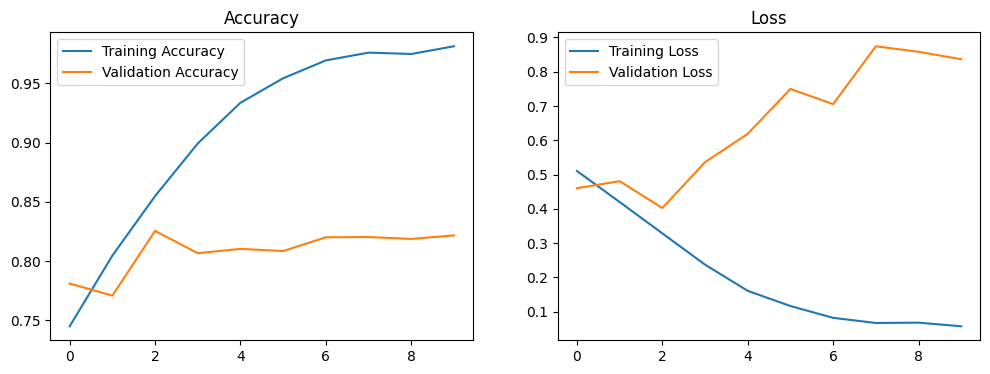

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title("Loss")

plt.show()

In [36]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

def predict_image(path):
    img = load_img(path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    prediction = model.predict(img_array)[0][0]
    label = "Dog" if prediction > 0.5 else "Cat"

    print(f"Prediction: {label} (score={prediction:.4f})")

In [39]:
predict_image(r"C:\Users\KEITH FERNANDES\OneDrive\Desktop\Cat v Dog Classifier\PetImages\Cat\0.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Prediction: Cat (score=0.0001)


In [40]:
predict_image(r"C:\Users\KEITH FERNANDES\OneDrive\Desktop\Cat v Dog Classifier\PetImages\Dog\18.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction: Dog (score=0.9573)
